# Výpočet tepové frekvence z EKG signálu 
## Vypracoval Marek Tremel a Radek Novák, F23211 a F23181

**Zadání** : Ve zdrojové databázi najdete celkem 18 měření EKG signálu pro různé věkové skupiny. Signál
obsahuje různé anomálie a nemusí být vždy centralizován podle vodorovné osy. EKG signál
obsahuje dominantní peaky, které se nazývají R vrcholy. Vzdálenost těchto vrcholů určuje dobu
mezi jednotlivými tepy. Počet tepů za minutu je tedy počet R vrcholů v signálu o délce jedné
minuty. Navrhněte algoritmus, který bude automaticky detekovat počet R vrcholů v EKG
signálech a prezentujte tepovou frekvenci při jednotlivých jízdách/měřeních. Vás algoritmus
následně otestujte na databázi MIT-BIH https://physionet.org/content/nsrdb/1.0.0/ a
prezentujte jeho úspěšnost vzhledem k anotovaným datům z databáze.

----------



## Použité knihovny

In [12]:
import wfdb
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt


## Načtení pracovního adresáře

In [13]:
# Hlavní adresář se složkami EKG měření
main_directory = "../data/ekg"

# Načtení seznamu složek
folders = sorted([f for f in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, f))])[:5]
print(f"Nalezené složky: {folders}")

Nalezené složky: ['100001', '100002', '103001', '103002', '103003']


## Parametry pro nastavení zpracování dat

In [14]:
lowcut = 0.5  # Dolní hranice pásmové filtrace (Hz)
highcut = 50.0  # Horní hranice pásmové filtrace (Hz)
filter_order = 4  # Pořadí filtru
threshold = 0.5  # Práh pro detekci R vrcholů

## Pásmová filtrace

Proces, který propouští signály v určitém frekvenčním rozsahu a zároveň potlačuje signály mimo toto pásmo. 
1. Výpočet Nyquistovy frekvence: Nyquistova frekvence je polovina vzorkovací frekvence (fs). Je to maximální frekvence, kterou lze správně reprezentovat při dané vzorkovací frekvenc
2. Normalizace mezních frekvencí: Dolní a horní mezní frekvence jsou normalizovány vzhledem k Nyquistově frekvenci.
3. Funkce *butter* z knihovny *scipy.signal* navrhne Butterworthův filtr s daným řádem a normalizovanými mezními frekvencemi. Výstupem jsou koeficienty filtru *b* a *a*
4. Funkce *filtfilt* z knihovny *scipy.signal* aplikuje navržený filtr na vstupní signál. Tato funkce provádí obousměrné filtrování, což znamená, že signál je filtrován dopředu i dozadu, aby se minimalizovalo fázové zkreslení.

In [15]:
def bandpass_filter(signal, lowcut, highcut, fs, order):
    """Funkce pro pásmovou filtrační metodu

    Args:
        signal: vstupní signál, který má být filtrován.
        lowcut: dolní mez frekvenčního pásma
        highcut: horní mez frekvenčního pásma.
        fs: vzorkovací frekvence signálu.
        order: řád filtru, který určuje strmost filtru.

    Returns:
        Filtrovaný signál.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

1. Procházení složek
2. Načítání signálů
3. Předzpracování signálu:
    - Normalizace: Signál je normalizován na nulový průměr a jednotkovou směrodatnou odchylku.
    - Filtrace: Aplikuje se pásmová propust, aby se odstranil šum a zdůraznily relevantní frekvence.
4. Detekce R-vln:
    - Derivace: Spočítá se derivace signálu, aby se zvýraznily změny v signálu.
    - Nulové průchody: Hledají se nulové průchody derivace, které odpovídají potenciálním R-vlnám (vrcholům srdečního tepu).
    - Filtrování vrcholů: Nulové průchody jsou filtrovány podle amplitudy, aby se odstranily nechtěné vrcholy.
5. Výpočet tepové frekvence:
    - Intervaly R-R: Spočítají se intervaly mezi detekovanými R-vlnami.
    - Průměrná tepová frekvence: Vypočítá se průměrná tepová frekvence na základě intervalů R-R.
6. Ukládání výsledků: Pro každou složku (měření) se uloží název složky a vypočítaná tepová frekvence.
7. Vykreslení grafu: Na závěr se vykreslí sloupcový graf, který zobrazuje tepovou frekvenci pro jednotlivá měření.

In [ ]:



# Uložení výsledků BPM pro každé měření
bpm_results = np.empty((0, 2), dtype=object)

for folder in folders:
    
    ekg_directory = os.path.join(main_directory, folder)
    files = os.listdir(ekg_directory)
    signal_basenames = set(f.split(".")[0] for f in files if f.endswith("ECG.dat"))


    if len(signal_basenames) > 0:
        signal_basename = list(signal_basenames)[0]
        record_path = os.path.join(ekg_directory, signal_basename)

        # Načtení signálu
        record = wfdb.rdsamp(record_path)
        signal = record[0][:, 0]  # První kanál
        fields = record[1]

        # Parametry
        sampling_frequency = fields["fs"]  # Vzorkovací frekvence (Hz)
        

        # Normalizace signálu
        # Tak, aby měl nulový průměr a jednotkovou směrodatnou odchylku
        signal_normalized = (signal - np.mean(signal)) / np.std(signal)

        
        # Aplikace filtrace
        try:
            signal_processed = bandpass_filter(signal_normalized, lowcut, highcut, sampling_frequency, filter_order)
        except ValueError as e:
            print(f"Chyba filtrace: {e}")
            signal_processed = signal_normalized

        # Derivace signálu je užitečná pro detekci změn v signálu, jako jsou vrcholy a průchody nulou. 
        # V kontextu EKG signálu se derivace používá k detekci R vrcholů, které odpovídají srdečním úderům.
        derivative = np.gradient(signal_processed)

        # Hledání nulových průchodů podle derivace
        zero_crossings = np.where((derivative[:-1] > 0) & (derivative[1:] < 0))[0]

        # Filtrace nulových průchodů podle prahu
        peaks = zero_crossings[(signal_processed[zero_crossings] > threshold) & (zero_crossings < len(signal_processed))]


        # Výpočet tepové frekvence
        # Kontrola počtu detekovaných R vrcholů
        if peaks.size > 1:
            # Výpočet intervalů mezi R vrcholy
            # np.diff(peaks) vypočítá rozdíly mezi po sobě jdoucími indexy vrcholů, což představuje počet vzorků mezi vrcholy.
            # Dělením vzorkovací frekvencí (sampling_frequency) se tyto rozdíly převedou na časové intervaly v sekundách.
            r_peak_intervals = np.diff(peaks) / sampling_frequency
            # Výpočet průměrné tepové frekvence:
            # np.mean(r_peak_intervals) vypočítá průměrný interval mezi R vrcholy.
            # Tepová frekvence (BPM) je rovna 60 děleno průměrným intervalem mezi R vrcholy.
            # Pokud nebyly detekovány žádné R vrcholy, je tepová frekvence nastavena na 0.
            heart_rate = 60 / np.mean(r_peak_intervals) if r_peak_intervals.size > 0 else 0
        else:
            heart_rate = 0

        print(f"Složka: {folder}, Počet detekovaných R vrcholů: {len(peaks)}, Průměrná tepová frekvence: {heart_rate:.2f} BPM")

        # Uložení výsledků BPM
        bpm_results = np.vstack((bpm_results, [folder, heart_rate]))




Složka: 100001, Počet detekovaných R vrcholů: 186287, Průměrná tepová frekvence: 128.35 BPM
Složka: 100002, Počet detekovaných R vrcholů: 184334, Průměrná tepová frekvence: 127.48 BPM
Složka: 103001, Počet detekovaných R vrcholů: 213744, Průměrná tepová frekvence: 147.21 BPM
Složka: 103002, Počet detekovaných R vrcholů: 203456, Průměrná tepová frekvence: 141.16 BPM
Složka: 103003, Počet detekovaných R vrcholů: 219675, Průměrná tepová frekvence: 152.54 BPM


## Vykreslení grafu

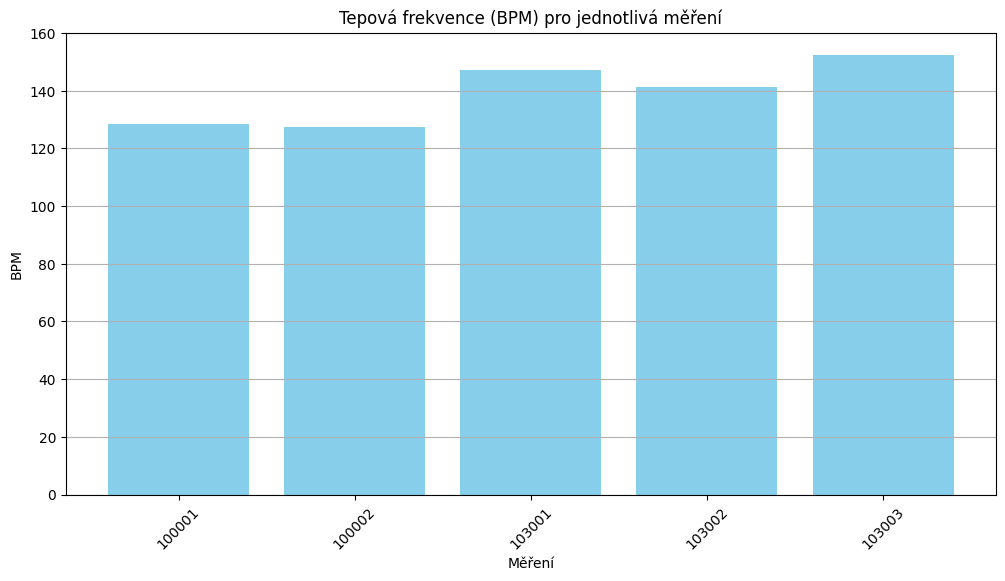

In [17]:
folders = bpm_results[:, 0]
bpm_values = bpm_results[:, 1].astype(float)

plt.figure(figsize=(12, 6))
plt.bar(folders, bpm_values, color="skyblue")
plt.title("Tepová frekvence (BPM) pro jednotlivá měření")
plt.xlabel("Měření")
plt.ylabel("BPM")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

## Slovni hodnocení

V rámci projektu zaměřeného na výpočet tepové frekvence z EKG signálu jsem se musel soutředit na to, jak efektivně načíst data a implementovat jednotlivé algoritmy pro zpracování dat.

Jakmile jsem načetl a předpracoval EKG signály, kde jsem použil normalizaci a pásmovou filtraci pomocí Butterworthova filtru, abych odstranil šum a zvýraznil relevantní frekvence.  
Pro detekci R-vrcholů jsem aplikoval derivaci signálu a hledal nulové průchody, které jsem dále filtroval podle stanoveného prahu. 
Na základě detekovaných R-vrcholů jsem vypočítal průměrné intervaly mezi tepy (R-R intervaly) a následně průměrnou tepovou frekvenci.

Na tomto projektu jsem si vyzkoušel praktický vhled do zpracování EKG signálů, pomocí různých metod a algoritmů v Pythonu.

1. [Pásová filtrace](https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter)
2. [Práce s EKG data](https://www.indigits.com/post/2022/10/ecg_python/)
3. [ChatGPT](https://chatgpt.com/)
